# STA4042 Project: AIS Constructor Clustering

*Zhecheng Ren 121090464*

*Zhiyuan Gao 121090136*

*November 26, 2024*

---

## Table of Content

__Section 1: Data Preprocessing__

&emsp; 1.1 Data Loading

&emsp; 1.2 Data Summary

&emsp; 1.3 Quality Control (Outlier Treatment)

&emsp; 1.4 (Additional) Feature Computation

&emsp; 1.5 Feature Selection

__Section 2: Signature Extraction__

&emsp; 2.1 Synchronization Errors

&emsp; 2.2 Regularity of Messages

&emsp; 2.3 Sampling of STOs & Slot Numbers
 
&emsp; 2.4 Alternation Between Channels

&emsp; 2.5 Signature Aggregation

__Section 3: Clustering and Evaluation__

&emsp; 3.1 Z-Score Normalization

&emsp; 3.2 Correlation Between Signatures

&emsp; 3.3 Part I: Unsupervised Learning with K-Means

&emsp; 3.4 Part II: Supervised Learning with KNN

&emsp; 3.5 Result Combination

&emsp; 3.6 Visualization and Evaluation

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import wasserstein_distance
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

sns.set_theme()

## Section 1: Data Preprocessing

### 1.1 Data Loading

Read in all 719 csv files and store them in a list.

_NB: File "640.csv" is not provided in the folder._


In [2]:
# read in all the csv files and store them in a list
data_lst = []
for i in range(721):
    file_path = "../data/" + str(i) + ".csv"
    try:
        data = pd.read_csv(file_path, sep=";").replace(-1, np.nan)
    except FileNotFoundError:
        continue
    data_lst.append(data)


print("Number of files read: ", len(data_lst))
print("Number of features: ", len(data_lst[0].columns))
data_lst[0].head()


Number of files read:  720
Number of features:  21


,channelNumber,id,NavStatus,SlotOffset,SlotNumber,STO,SlotIncrement,KeepFlag,TS,Lat,...,Sog,thresholdSog,Course,Heading,ChangeHeading,RepeatIndicator,SpecialManoeuvre,AISVersion,toa,DiffToa
0,1,5,NaN,NaN,NaN,NaN,NaN,NaN,1711,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,10,93352.297516,0.0000
1,2,5,NaN,NaN,NaN,NaN,NaN,NaN,1674,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,10,94431.318481,1079.0210
2,1,5,NaN,NaN,NaN,NaN,NaN,NaN,1675,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,10,94791.343842,360.0254
3,1,5,NaN,NaN,NaN,NaN,NaN,NaN,1707,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,10,171051.778839,76260.4350
4,2,5,NaN,NaN,NaN,NaN,NaN,NaN,1681,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,10,171411.082489,359.3036


### 1.2 Data Summary

Concatenate all the data frames and extract overall information for each feature.

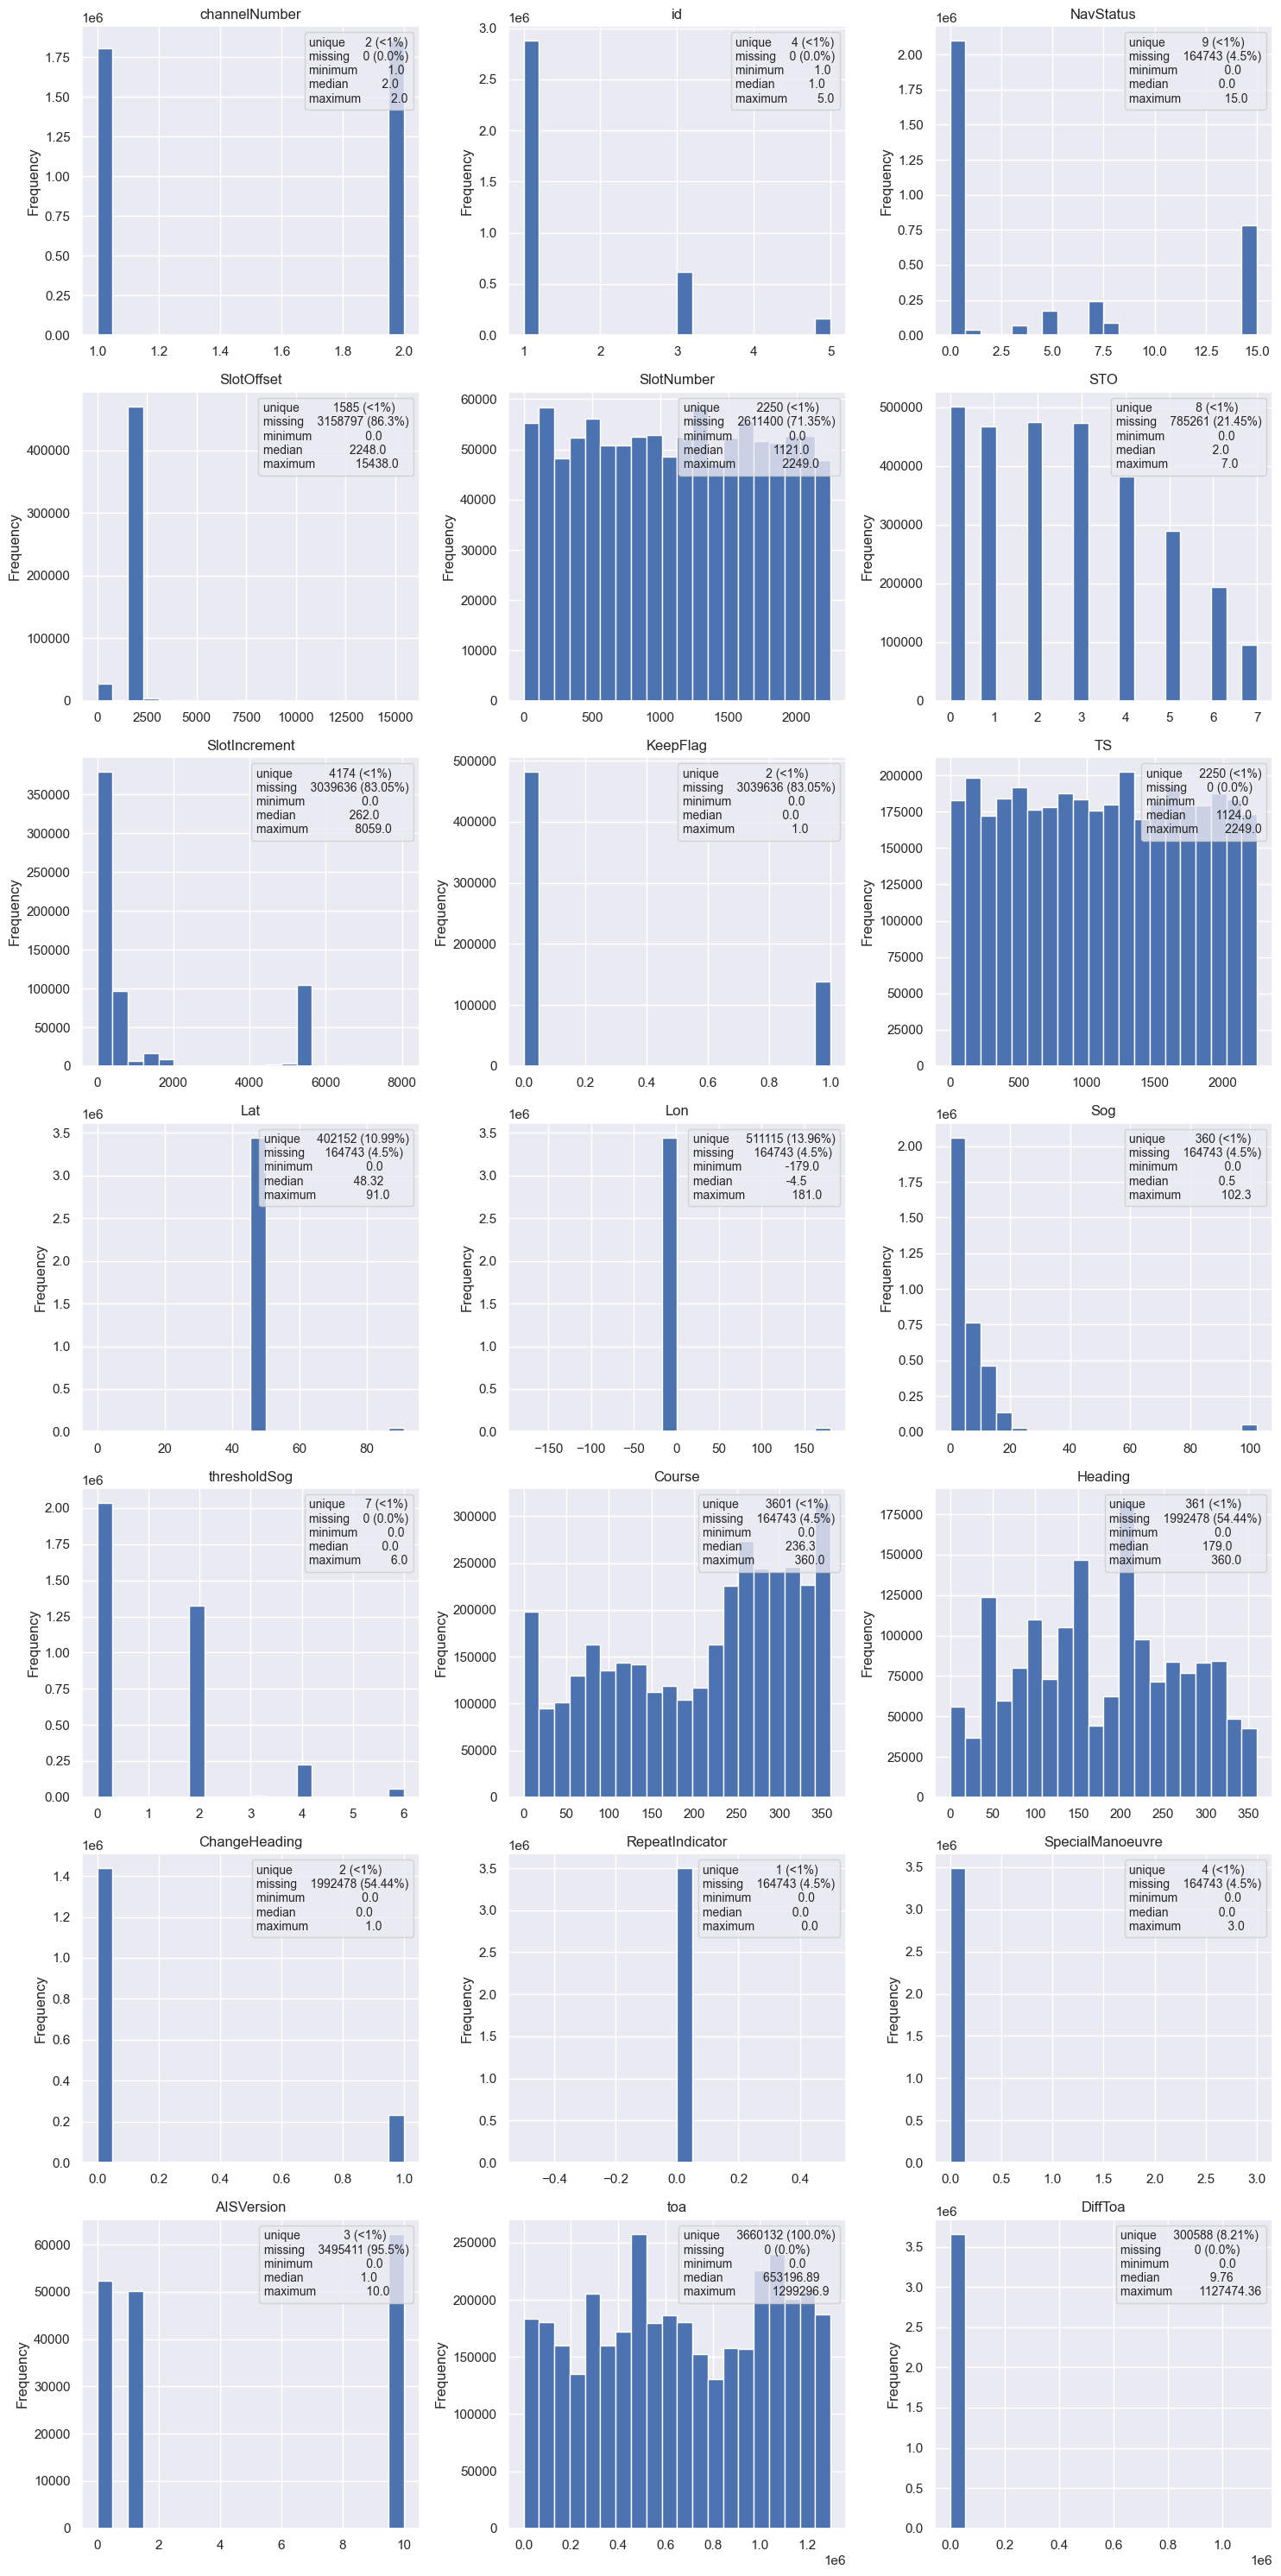

In [3]:
# concatenate all the data frames
data_concat = pd.concat(data_lst)


# derive summary and plot the distribution of values for each column
def data_summary(data):
    n_rows = data.shape[0]
    n_unique = data.nunique()
    n_missing = data.isnull().sum()
    percent_unique = n_unique / n_rows * 100
    percent_missing = n_missing / n_rows * 100
    percent_unique = percent_unique.apply(
        lambda x: "<1%" if x > 0 and x < 1 else str(round(x, 2)) + "%"
    )
    percent_missing = percent_missing.apply(
        lambda x: "<1%" if x > 0 and x < 1 else str(round(x, 2)) + "%"
    )
    unique = n_unique.astype(str) + " (" + percent_unique + ")"
    missing = n_missing.astype(str) + " (" + percent_missing + ")"
    minimum = data.min().round(2)
    median = data.median().round(2)
    maximum = data.max().round(2)
    summary = pd.DataFrame(
        {
            "unique": unique,
            "missing": missing,
            "minimum": minimum,
            "median": median,
            "maximum": maximum,
        }
    )
    return summary


summary = data_summary(data_concat)
fig, axes = plt.subplots(7, 3, figsize=(15, 30))
for i, col in enumerate(data_concat.columns):
    ax = axes[i // 3, i % 3]
    data_concat[col].plot(kind="hist", ax=ax, title=col, bins=20)
    ax.legend(
        [summary.loc[col].to_string()],
        loc="upper right",
        fontsize=10,
        handlelength=0,
        handletextpad=0,
    )
plt.tight_layout()
plt.show()


### 1.3 Quality Control (Outlier Treatment)

A quality control is conducted over the columns `SlotIncrement` and `SlotOffset`. Since the data in these two columns exhibit multimodal distributions, we first fit a Gaussian Mixtrue Model over each of them, then drop the data with low fitted probability.

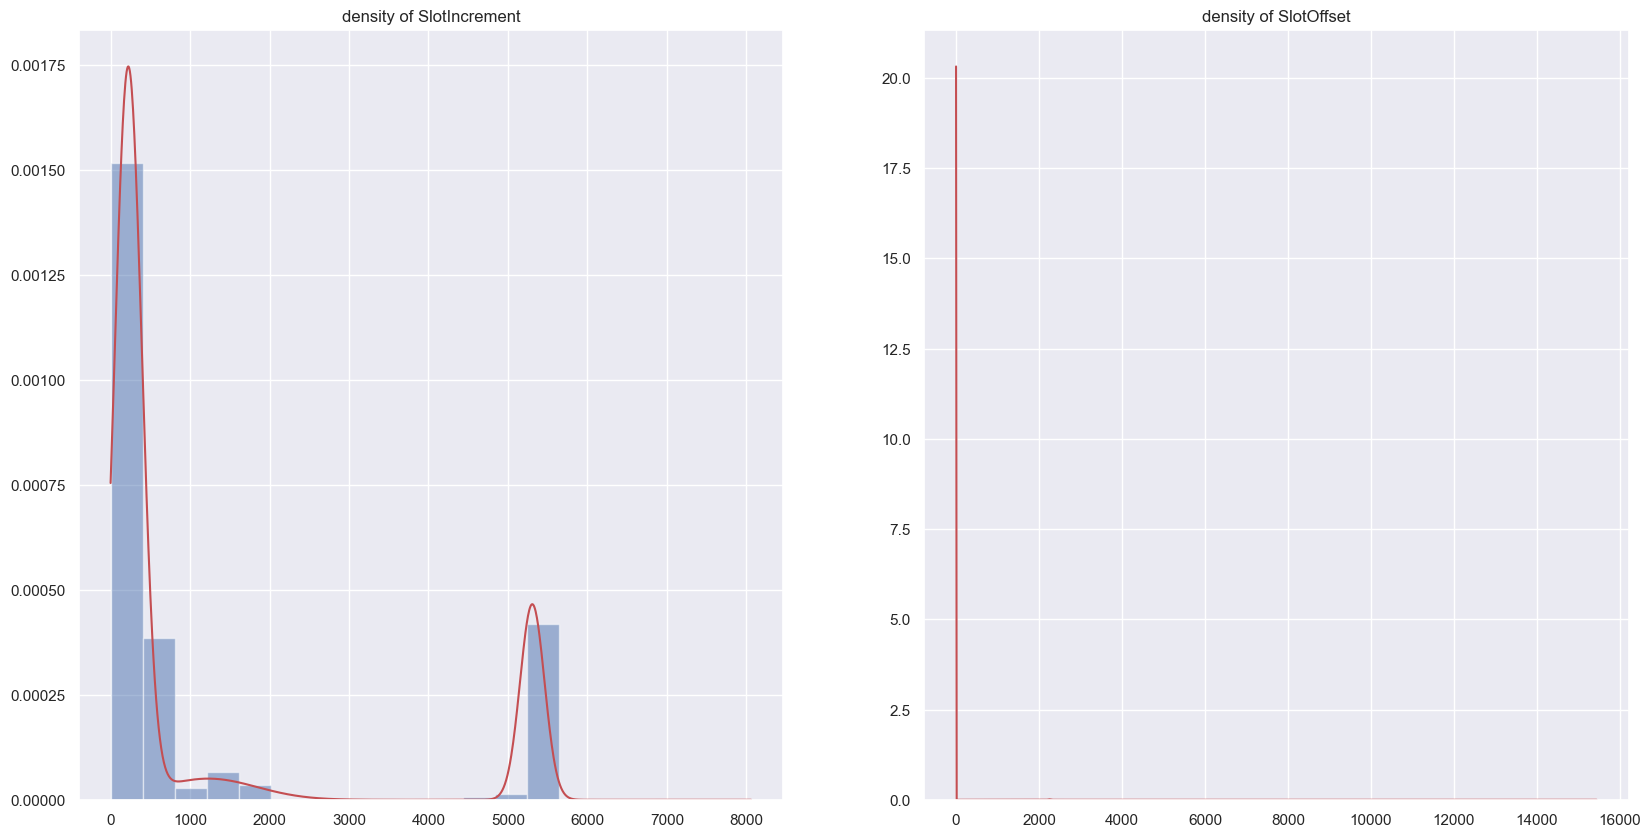

Number of messages before dropping outliers:  3660154
Number of messages after dropping outliers:  3649156


In [4]:
def drop_outlier(df_lst, df_concat, col_names, drop_percentage=0.01):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for i, col in enumerate(col_names):
        data = df_concat[col].dropna().values.reshape(-1, 1)
        gmm = GaussianMixture(n_components=3, random_state=42)
        gmm.fit(data)

        x = np.linspace(data.min(), data.max(), 1000)  # visualize the gmm fitting
        x_pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
        ax = axes[i]
        ax.hist(data, bins=20, density=True, alpha=0.5)
        ax.plot(x, x_pdf, "-r")
        ax.set_title("density of " + col)

        log_probabilities = gmm.score_samples(data)
        threshold = np.percentile(log_probabilities, 100 * drop_percentage)

        for df in df_lst:
            dat = df[col].dropna().values.reshape(-1, 1)
            if len(dat) != 0:
                score = gmm.score_samples(dat)
                df.loc[df[col].notna(), "GMMScore"] = score
                df.drop(
                    df.loc[
                        (df["GMMScore"].notna()) & (df["GMMScore"] < threshold)
                    ].index,
                    inplace=True,
                )
                df.drop(columns=["GMMScore"], inplace=True)
    plt.show()
    return df_lst


n_rows = data_concat.shape[0]
qc_col_names = ["SlotIncrement", "SlotOffset"]
data_lst = drop_outlier(data_lst, data_concat, qc_col_names, drop_percentage=0.01)

print("Number of messages before dropping outliers: ", n_rows)
data_concat = pd.concat(data_lst)
n_rows = data_concat.shape[0]
print("Number of messages after dropping outliers: ", n_rows)

### 1.4 (Additional) Feature Computation

Based on the above plot and commonsense reasoning, we can compute several additional features that may be helpful to the subsequent analysis. The addtional features and their computation ideas are summarized as follows:

**`ChangeCourse`**: 

A boolean indicating whether the course of the ship is changing at a given moment. The computation steps are as follows:
1. First compute `ChangeHeadingRate` using features `Heading` and `DiffToa`;
2. Then fit a logistic regression model using `ChangeHeadingRate` and `ChangeHeading` to get a threshold for "direction change";
3. Then compute `ChangeCourseRate` using features `Course` and `DiffToa`;
4. Finally use the fitted model and `ChangeCourseRate` to predict `ChangeCourse`.


<Axes: title={'center': 'ChangeCourse'}, ylabel='Frequency'>

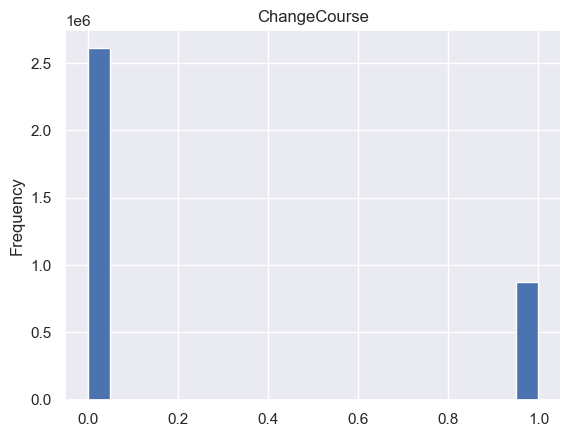

In [5]:
# fit a logistic regression model to predict `ChangeCourse`
heading_diff_lst = []
time_diff_lst = []
change_heading_lst = []
for data in data_lst:
    row_idx = data["Heading"].notna()
    heading_diff_lst.append(data.loc[row_idx, "Heading"].diff().dropna())
    time_diff_lst.append(data.loc[row_idx, "DiffToa"][1:])
    change_heading_lst.append(data.loc[row_idx, "ChangeHeading"][1:])
heading_diff_lst = abs(pd.concat(heading_diff_lst))
time_diff_lst = pd.concat(time_diff_lst)
change_heading_lst = pd.concat(change_heading_lst)
droped_idx = np.union1d(
    np.intersect1d(np.where(heading_diff_lst < 2), np.where(change_heading_lst == 1)),
    np.intersect1d(np.where(heading_diff_lst > 5), np.where(change_heading_lst == 0)),
)  # quality control
change_heading_rate_lst = np.delete(
    heading_diff_lst / time_diff_lst, droped_idx
).reshape(-1, 1)
change_heading_lst = np.delete(change_heading_lst, droped_idx)
model = LogisticRegression()
model.fit(change_heading_rate_lst, change_heading_lst)
for data in data_lst:
    not_nan_row_idx = data["Course"].notna()
    course_diff_lst = data.loc[not_nan_row_idx, "Course"].diff().dropna()
    time_diff_lst = data.loc[not_nan_row_idx, "DiffToa"][1:]
    change_course_rate_lst = abs(course_diff_lst) / time_diff_lst
    if len(change_course_rate_lst) != 0:
        change_course = model.predict(change_course_rate_lst.values.reshape(-1, 1))
        change_course = np.insert(change_course, 0, 0)
        data.loc[not_nan_row_idx, "ChangeCourse"] = change_course
    data.loc[data["Course"].isna(), "ChangeCourse"] = np.nan

# plot the distribution of added columns
data_concat = pd.concat(data_lst)
data_concat["ChangeCourse"].plot(kind="hist", bins=20, title="ChangeCourse")

### 1.5 Feature Selection

Based on the plot in 1.2, the verification below, and commonsense reasoning, we can drop several features for the following reasons:

1. `Lat`: Does not related to constructor signitures.
2. `Lon`: Does not related to constructor signitures.
3. `Course`: Does not related to constructor signitures. What useful is `ChangeCourse`
4. `Heading`: Does not related to constructor signitures.
5. `ChangeHeading`: Does not related to constructor signitures.
6. `RepeatIndicator`: $100\%$ data take value $0$, which will not affect the subsequent analysis.
7. `SpecialManoeuvre`: $>99.5\%$ data take value $1$, which will not affect the subsequent analysis.
8. `AISVersion`: Does not related to constructor signitures. And too many missing values.
9. `toa`: Does not related to constructor signitures. What useful is `DiffToa`.


SpecialManoeuvre
0.0    3471709 (99.64%)
3.0          6364 (<1%)
1.0          6339 (<1%)
2.0             1 (<1%)
Name: count, dtype: object


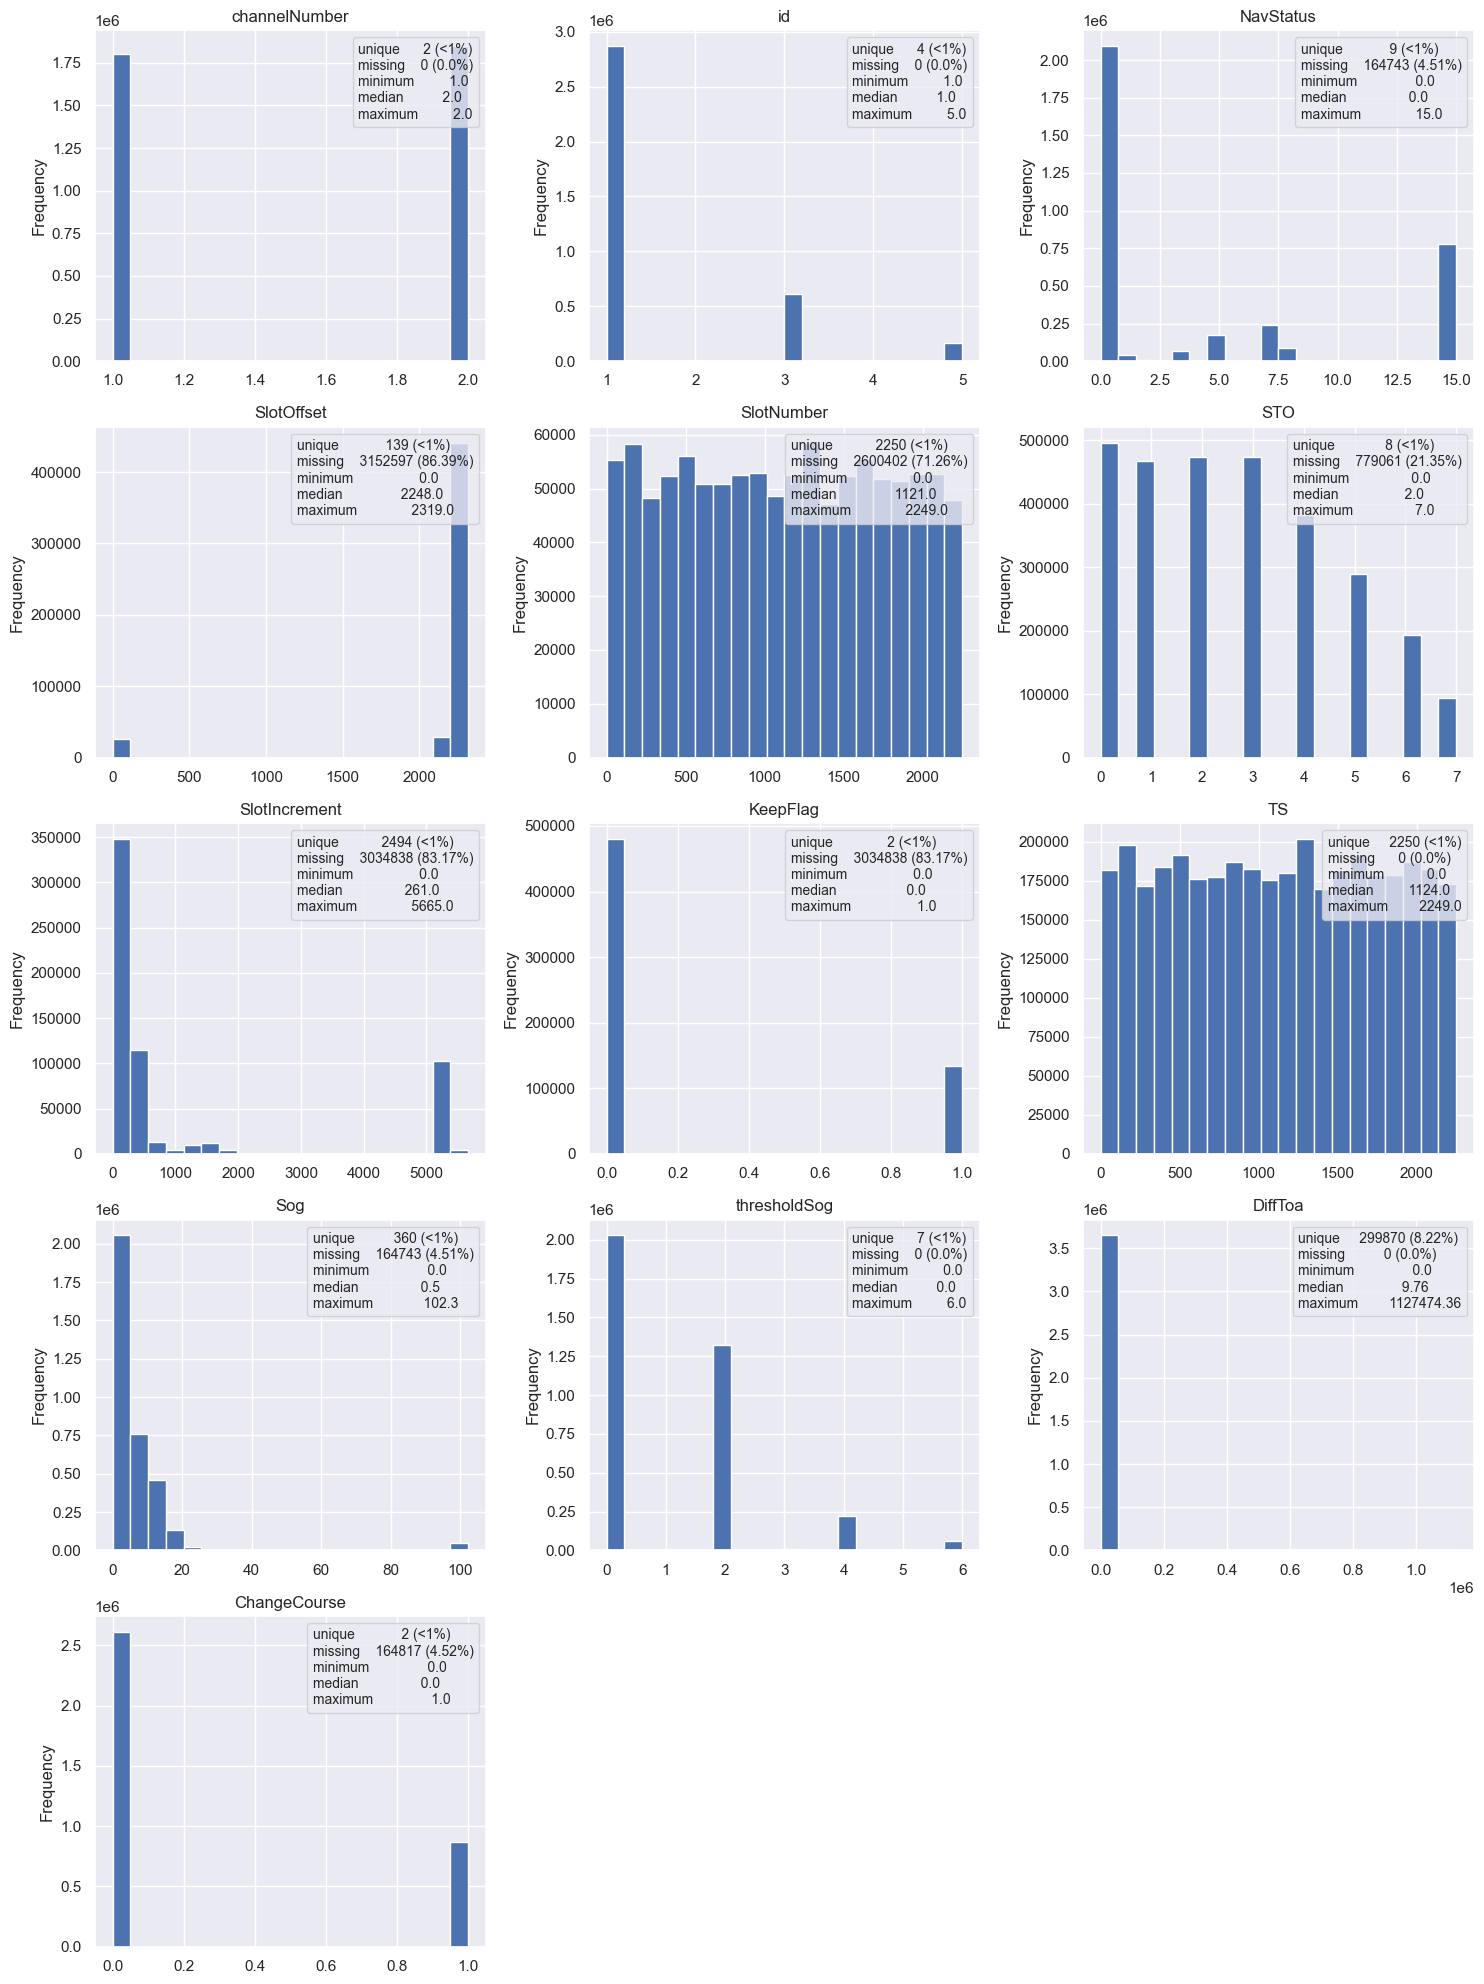

In [6]:
# Check the percentage of different values in `SpecialManoeuvre`
n_special = data_concat["SpecialManoeuvre"].value_counts()
percent_special = n_special / sum(n_special) * 100
percent_special = percent_special.apply(
    lambda x: "<1%" if x < 1 else str(round(x, 2)) + "%"
)
special = n_special.astype(str) + " (" + percent_special + ")"
print(special)

# Drop useless features
columns_to_drop = [
    "Lat",
    "Lon",
    "Course",
    "Heading",
    "ChangeHeading",
    "RepeatIndicator",
    "SpecialManoeuvre",
    "AISVersion",
    "toa",
]
for data in data_lst:
    for col in columns_to_drop:
        data.drop(columns=col, inplace=True)

# Visualize the distribution of values for each column again
data_concat = pd.concat(data_lst)
summary = data_summary(data_concat)
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
for i, col in enumerate(data_concat.columns):
    ax = axes[i // 3, i % 3]
    data_concat[col].plot(kind="hist", ax=ax, title=col, bins=20)
    ax.legend(
        [summary.loc[col].to_string()],
        loc="upper right",
        fontsize=10,
        handlelength=0,
        handletextpad=0,
    )
fig.delaxes(axes[4, 1])
fig.delaxes(axes[4, 2])

plt.tight_layout()
plt.show()

## Section 2: Signature Extraction

In order to cluster the constructors, we first need to extract several "constructor signatures" —— the characteristics that differ among AIS constructors. The signatures regarding the following five phenomena are extracted:

* Synchronization errors
* Regularity of messages depending on speed, acceleration, and course
* Sampling of STOs
* Sampling of slot numbers
* Alternation between channels

_NB: Due to missing data and insufficient data size for some ships, some signatures cannot be computed for them. We will leave these values as `NaN` and treat them specially during clustering._

### 2.1 Synchronization Errors

For the AIS transponders on each ship, the synchronization error can accumulate and result in the difference between `SlotNumber` and `TS` in some messages. For each ship, we compute the `synchronization error rate` as a signature.

$$
\text{Synchronization error rate} = \frac{\text{Number of messages with different values of SlotNumber and TS}}{\text{Total number of messages}}
$$

_NB: If `synchronization error rate` is computed to be $0$ or $1$, it is likely due to the insufficient sample size. We will reset these outliers to be `NaN`._

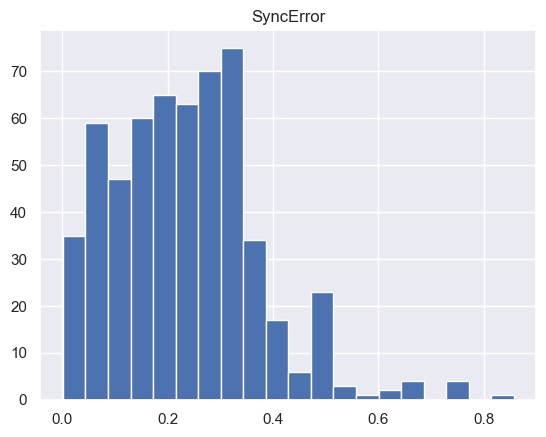

In [7]:
# Initialize an empty list to store the SyncError for each boat
sync_errors = []

# Iterate over each dataframe in data_lst
for data in data_lst:
    row_idx = data["SlotNumber"].notna()
    # Calculate the SyncError for the current boat
    sync_error_count = (
        data.loc[row_idx, "TS"] != data.loc[row_idx, "SlotNumber"]
    ).sum()
    sync_error_rate = sync_error_count / data.shape[0]
    # Deal with outliers
    if sync_error_rate == 0 or sync_error_rate == 1:
        sync_error_rate = np.nan
    sync_errors.append(sync_error_rate)

# Plot the distribution of SyncError
plt.hist(sync_errors, bins=20)
plt.title("SyncError")
plt.show()


### 2.2 Regularity of Messages

Any AIS transponder is required to send messages with a certain frequency depending on the ship's dynamic conditions (as shown in the table below). However, transponders from some constructors may not respect this regularity, leading to the signature named `emission variants`. 

| Ship's dynamic conditions                                | Nominal reporting interval |
|----------------------------------------------------------|----------------------------|
| Ship at anchor or moored and not moving faster than 3 knots | 3 min                    |
| Ship at anchor or moored and moving faster than 3 knots  | 10 s                     |
| Ship 0-14 knots                                          | 10 s                     |
| Ship 0-14 knots and changing course                     | 3 1/3 s                  |
| Ship 14-23 knots                                         | 6 s                      |
| Ship 14-23 knots and changing course                    | 2 s                       |
| Ship >23 knots                                           | 2 s                       |
| Ship >23 knots and changing course                      | 2 s                       |

The `emission variants` for each ship can be computed in the following way:

1. According to the table above, we first derive the `ideal emmission difference` for each massage based on the information in `id`, `NavStatus`, `thresholdSog`, and `ChangeCourse`
2. Suppose $P$ is the empirical measure of `ideal emmission difference`, $Q$ is the empirical measure of `DiffToa`, $W_p (\cdot, \cdot)$ is the p-Wasserstein distance between two measures, then

$$
\text{emission variants} = W_1(P, Q)
$$

_NB: The 1-Wasserstein distance is selected here because it is a commonly-used distance to measure the difference between two distributions. Unlike Cross Emtropy or KL-divergencce, it is symmetric and does not easily degenerate to $0$ and $1$._

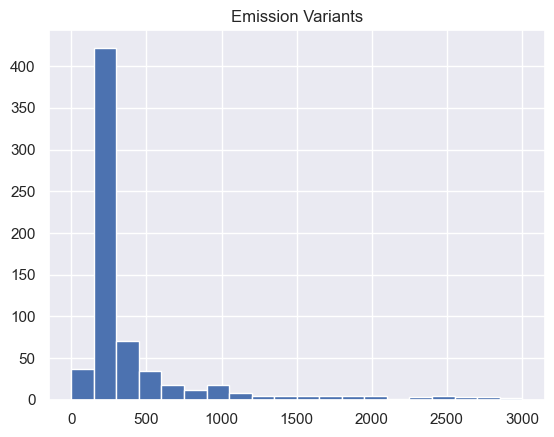

In [8]:
def ideal_message_frequency(df):
    conditions = [
        df["id"] == 5,
        ((df["NavStatus"] == 1) | (df["NavStatus"] == 5)) & df["thresholdSog"] == 0,
        ((df["NavStatus"] == 1) | (df["NavStatus"] == 5)) & df["thresholdSog"] > 0,
        (df["thresholdSog"] < 3) & (df["ChangeCourse"] == 0),
        (df["thresholdSog"] < 3) & (df["ChangeCourse"] == 1),
        (df["thresholdSog"] >= 3)
        & (df["thresholdSog"] <= 5)
        & (df["ChangeCourse"] == 0),
        (df["thresholdSog"] >= 3)
        & (df["thresholdSog"] <= 5)
        & (df["ChangeCourse"] == 1),
        df["thresholdSog"] > 5,
    ]
    outputs = [360.0, 180.0, 10.0, 10.0, 10 / 3, 6.0, 2.0, 2.0]
    ideal_emission_difference = np.select(conditions, outputs, 0.0)
    return pd.Series(ideal_emission_difference)


emission_variants = []
for data in data_lst:
    emission_variant = wasserstein_distance(
        data["DiffToa"], ideal_message_frequency(data)
    )
    emission_variants.append(emission_variant)

# Plot the distribution of Emission Variants
plt.hist(emission_variants, bins=20, range=(0, 3000))
plt.title("Emission Variants")
plt.show()

### 2.3 Sampling of STOs & Slot Numbers

The AIS transponders from different constructors may exhibit different STO & slot number sampling behavior. These two signatures —— `STO samplings` and `slot number samplings` —— are computed in the following ways:

1. Compute the first seven moments of the empirical distributions of `STO` / `TS`. Store these seven values in a vector.
2. Standardize this vector.
3. Summarize this seven-dimensional vector into a scalar (`STO samplings` / `slot number samplings`) using PCA.

_NB: The overall distribution of `STO` / `TS` is not equivalent to the sampling distribution of `STO` / `TS`. But if we assume the data are missing in a random manner, analysing the overall distribution is sufficient to uncover the sampling pattern._


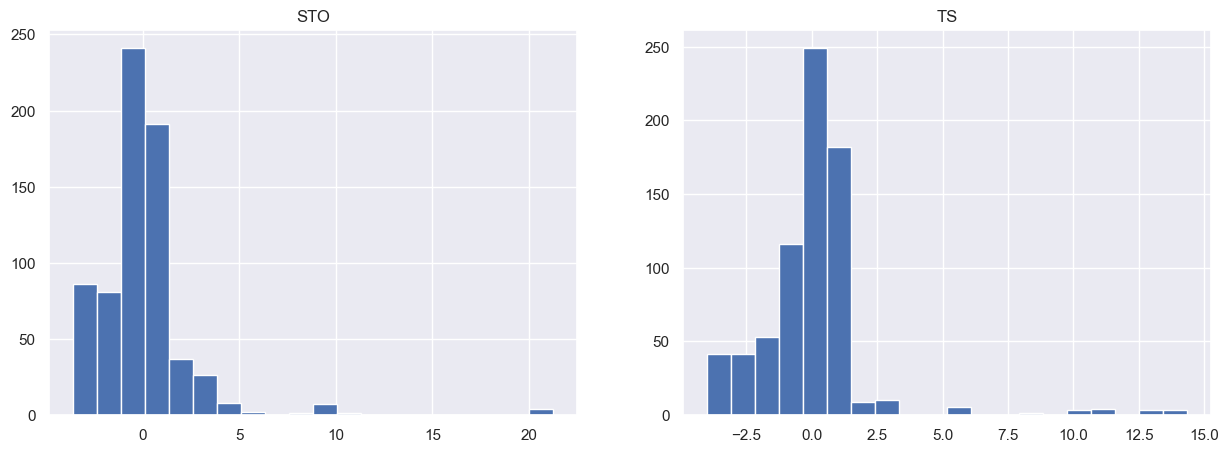

In [9]:
def extract_characteristic(sample):
    def moment(x, prob, k):
        return (np.power(x, k) * prob).sum()

    if sample.shape[0] == 0:
        return np.array([np.nan for _ in range(1, 8)])
    elif np.unique(sample).shape[0] == 1:
        return np.array([sample[0] ** k for k in range(1, 8)])
    else:
        x_min, x_max = sample.min(), sample.max()
        x_eval = np.arange(x_min, x_max + 1)
        kernel = gaussian_kde(sample)
        y = kernel(x_eval)
        characteristic_vector = np.array([moment(x_eval, y, k) for k in range(1, 8)])
        return characteristic_vector


def reduce_characteristic(characteristics):
    row_idx = ~np.isnan(characteristics).any(axis=1)
    reduced_characteristics = np.empty(characteristics.shape[0])
    safe_characteristics = characteristics[row_idx]
    scaled_characteristics = StandardScaler().fit_transform(safe_characteristics)
    reduced_characteristics[~row_idx] = np.nan
    reduced_characteristics[row_idx] = (
        PCA(n_components=1).fit_transform(scaled_characteristics).flatten()
    )
    return reduced_characteristics


STO_distribution_characteristics = []
slot_number_distribution_characteristics = []
for data in data_lst:
    # STO_distribution = data["STO"].value_counts()
    raw_STO = data["STO"]
    STO_distribution = raw_STO[~np.isnan(raw_STO)]
    raw_slot_number = data["TS"]
    slot_number_distribution = raw_slot_number[~np.isnan(raw_slot_number)]
    STO_distribution_characteristics.append(
        extract_characteristic(STO_distribution.values)
    )
    slot_number_distribution_characteristics.append(
        extract_characteristic(slot_number_distribution.values)
    )
    # characteristic = PCA(n_components=1).fit(characteristic_vector.reshape(1, -1))

STO_samplings = reduce_characteristic(np.array(STO_distribution_characteristics))
slot_number_samplings = reduce_characteristic(
    np.array(slot_number_distribution_characteristics)
)

# Plot the distribution of STO_distribution and TS_distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(STO_samplings, bins=20)
axes[0].set_title("STO")
axes[1].hist(slot_number_samplings, bins=20)
axes[1].set_title("TS")
plt.show()

### 2.4 Alternation Between Channels

AIS transponders from some constructors may not alternate between channels when sending consecutive messages. This preference for a certain channel is a signature named `channel preference`. It can be computed in the following way:

$$
\text{Channel preference} = \frac{\text{Number of messages in channel 1}}{\text{Total number of messages}}
$$

_NB 1: If AIS transponder does alternate between channels, then `channel preference` will be close to $0.5$, otherwise close to $0$ or $1$._

_NB 2: If `channel preference` is computed to be $0$ or $1$, it is likely due to the insufficient sample size. We will reset these outliers to be `NaN`._

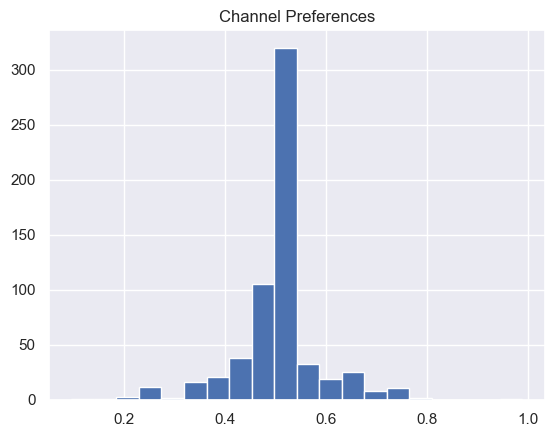

In [10]:
channel_preferences = []

for data in data_lst:
    channel_one_count = (data["channelNumber"] == 1).sum()
    channel_preference = channel_one_count / data.shape[0]
    if channel_preference == 0 or channel_preference == 1:
        channel_preference = np.nan
    channel_preferences.append(channel_preference)

# Plot the distribution of Channel Preferences
plt.hist(channel_preferences, bins=20)
plt.title("Channel Preferences")
plt.show()

### 2.5 Signature Aggregation

Aggregate all the signatures into one dataframe.

In [11]:
# Create a new dataframe with the Transponder Signature for each boat
aggregated_data = pd.DataFrame(
    {
        "SyncError": sync_errors,
        "EmissionVariant": emission_variants,
        "STOSampling": STO_samplings,
        "SlotNumberSampling": slot_number_samplings,
        "ChannelPreference": channel_preferences,
    }
)

aggregated_data

,SyncError,EmissionVariant,STOSampling,SlotNumberSampling,ChannelPreference
0,NaN,3888.893493,NaN,-1.361259,0.489437
1,0.050785,473.767010,0.177643,0.879564,0.478534
2,0.307087,276.991546,-0.070590,0.089189,0.496063
3,NaN,180.000000,-1.590852,2.699879,NaN
4,0.202970,200.690543,0.173435,0.357425,0.500000
...,...,...,...,...,...
715,0.085256,171.835624,0.062397,-0.593532,0.497492
716,0.283582,11304.974212,-0.962486,0.003166,0.462687
717,0.454545,215.965764,0.792143,-0.170060,0.727273
718,0.750000,3804.844375,0.995130,-1.080075,0.500000


## Section 3: Clustering and Evaluation

Since some signature values are missing for some ships, we conduct clustering using the following framework:

1. **Unsupervised learning** on data without missing signature
    + Estimate the number of clusters using the elbow method.
    + Do K-Means clustering to estimate their class label.

2. **Supervised learning** on data with missing signatures
    + Fit KNN models using data without missing signature and their estimated labels.
    + For each data with some missing signatures, using whatever signatures it has to predict its class label via the KNN model.

**This framework is a mixture of supervised and unsupervised learning methods.**

### 3.1 Z-Score Normalization

Before clustering, do Z-score normalization over each signature to put them into a comparable scale.

In [12]:
# Conduct Z-score normalize each column in the dataframe
aggregated_data = (aggregated_data - aggregated_data.mean()) / aggregated_data.std()
aggregated_data

,SyncError,EmissionVariant,STOSampling,SlotNumberSampling,ChannelPreference
0,NaN,0.125544,NaN,-0.620446,-0.145055
1,-1.319338,-0.108736,0.069803,0.400895,-0.270180
2,0.511822,-0.122235,-0.027738,0.040651,-0.069007
3,NaN,-0.128888,-0.625111,1.230574,NaN
4,-0.232044,-0.127469,0.068150,0.162910,-0.023823
...,...,...,...,...,...
715,-1.073062,-0.129448,0.024518,-0.270525,-0.052601
716,0.343892,0.634293,-0.378200,0.001443,-0.452055
717,1.565350,-0.126421,0.311265,-0.077511,2.584498
718,3.676242,0.119779,0.391027,-0.492286,-0.023823


### 3.2 Correlation Between Signatures

Before clustering, we visualize the correlation between signatures using a heatmap.

The heatmap below implies that the extracted signatures are nearly uncorrelated to each other, thereby reflecting independent aspects of the data. In this case, the data are usually good input for clustering and not necessary to go through dimension reduction.

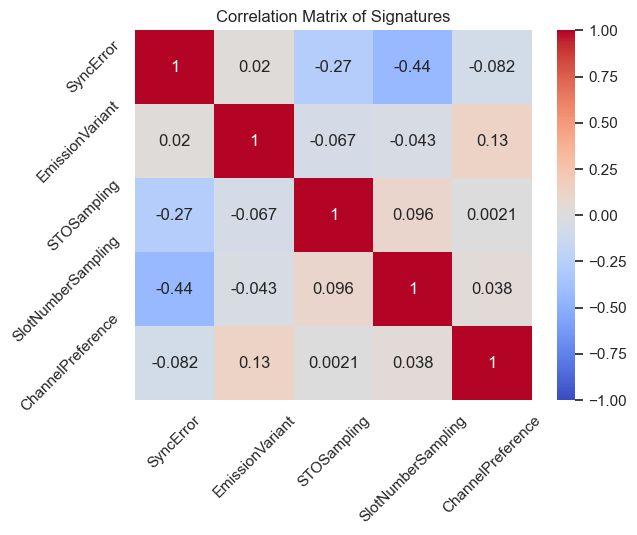

In [13]:
# Plot the correlation matrix of the aggregated data
corr = aggregated_data.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Correlation Matrix of Signatures")
plt.show()

### 3.3 Part I: Unsupervised Learning with K-Means

We first filter out the data without missing signature, and estimate their number of clusters using the elbow method.

When implementing the elbow method, we fit the model $10$ times and compute the mean of the inertia.

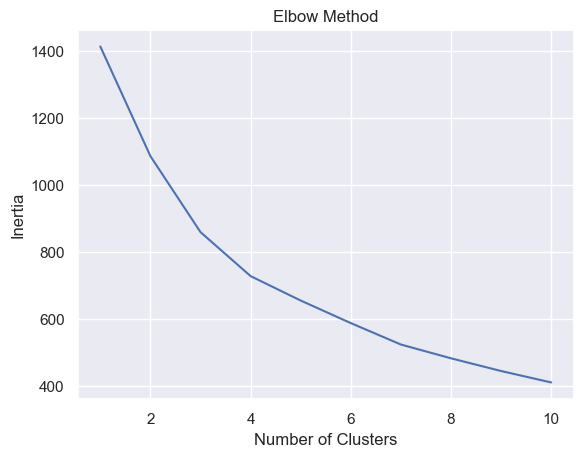

In [14]:
# Filter out the rows without nan values
complete_signatures = aggregated_data.dropna()
complete_signatures_index = complete_signatures.index

# Estimate the number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    for i in range(10):
        kmeans = KMeans(n_clusters=k, random_state=i)
        kmeans.fit(complete_signatures)
        inertia.append(kmeans.inertia_)
inertia = np.array(inertia).reshape(10, 10).mean(axis=1)

plt.plot(range(1, 11), inertia)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


From the above elbow plot, we find that an appropriate number of clusters is $4$.

Then we fit a K-Means model with number of clusters equals to $4$.

In [15]:
# Fit a K-Means model with 4 clusters
kmeans = KMeans(init="k-means++", n_clusters=4, random_state=0)
kmeans.fit(complete_signatures)
complete_signatures_labels = kmeans.labels_
n_ships = pd.Series(complete_signatures_labels).value_counts()
n_ships["Total"] = n_ships.sum()
n_ships

1        240
3        225
2         49
0         41
Total    555
Name: count, dtype: int64

### 3.4 Part II: Supervised Learning with KNN

Then we filter out the data with missing signatures. For each data, fit a KNN model using its existing signatures and predict its label.

In [16]:
# Filter out rows with nan values
partial_signatures = aggregated_data[aggregated_data.isna().any(axis=1)]
partial_signatures_index = partial_signatures.index

# Create a list of all possible combinations of features
from itertools import combinations
feature_combinations = []
for i in range(1, 6):
    feature_combinations.extend(combinations(complete_signatures.columns, i))

# Fit a KNN model for each combination of features
knn_models = {}
for combination in feature_combinations:
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(complete_signatures[list(combination)], complete_signatures_labels)
    knn_models[combination] = knn

# Predict the cluster label for each partial signature
partial_signatures_labels = []
for idx, row in partial_signatures.iterrows():
    features = tuple(row.dropna().index)
    knn = knn_models[features]
    X = row[list(features)].to_frame().T
    partial_signatures_label = knn.predict(X)
    partial_signatures_labels.append(int(partial_signatures_label[0]))

n_ships = pd.Series(partial_signatures_labels).value_counts()
n_ships["Total"] = n_ships.sum()
n_ships


1         53
3         46
0         41
2         25
Total    165
Name: count, dtype: int64

### 3.5 Result Combination

We combine the labels predicted either by K-Means or by KNN.

In [17]:
# Combine the predicted labels
complete_signatures_labels = pd.Series(complete_signatures_labels, index=complete_signatures_index)
partial_signatures_labels = pd.Series(partial_signatures_labels, index=partial_signatures_index)
all_signatures_labels = pd.concat([complete_signatures_labels, partial_signatures_labels])
all_signatures_labels = all_signatures_labels.sort_index()
n_ships = all_signatures_labels.value_counts()
n_ships["Total"] = n_ships.sum()
print(n_ships)

1        293
3        271
0         82
2         74
Total    720
Name: count, dtype: int64


In [18]:
print(all_signatures_labels)

0      3
1      1
2      3
3      1
4      1
      ..
715    1
716    3
717    0
718    3
719    1
Length: 720, dtype: int64


### 3.6 Visualization and Evaluation

We sort the rows of aggragated data by the predicted labels and plot the correlation matrix.

According to the heatmap below, the correlation values between signatures within one class are high, and the correlation values between signatures from different classes are low. Therefore, **our clustering method works very well on the dataset.**

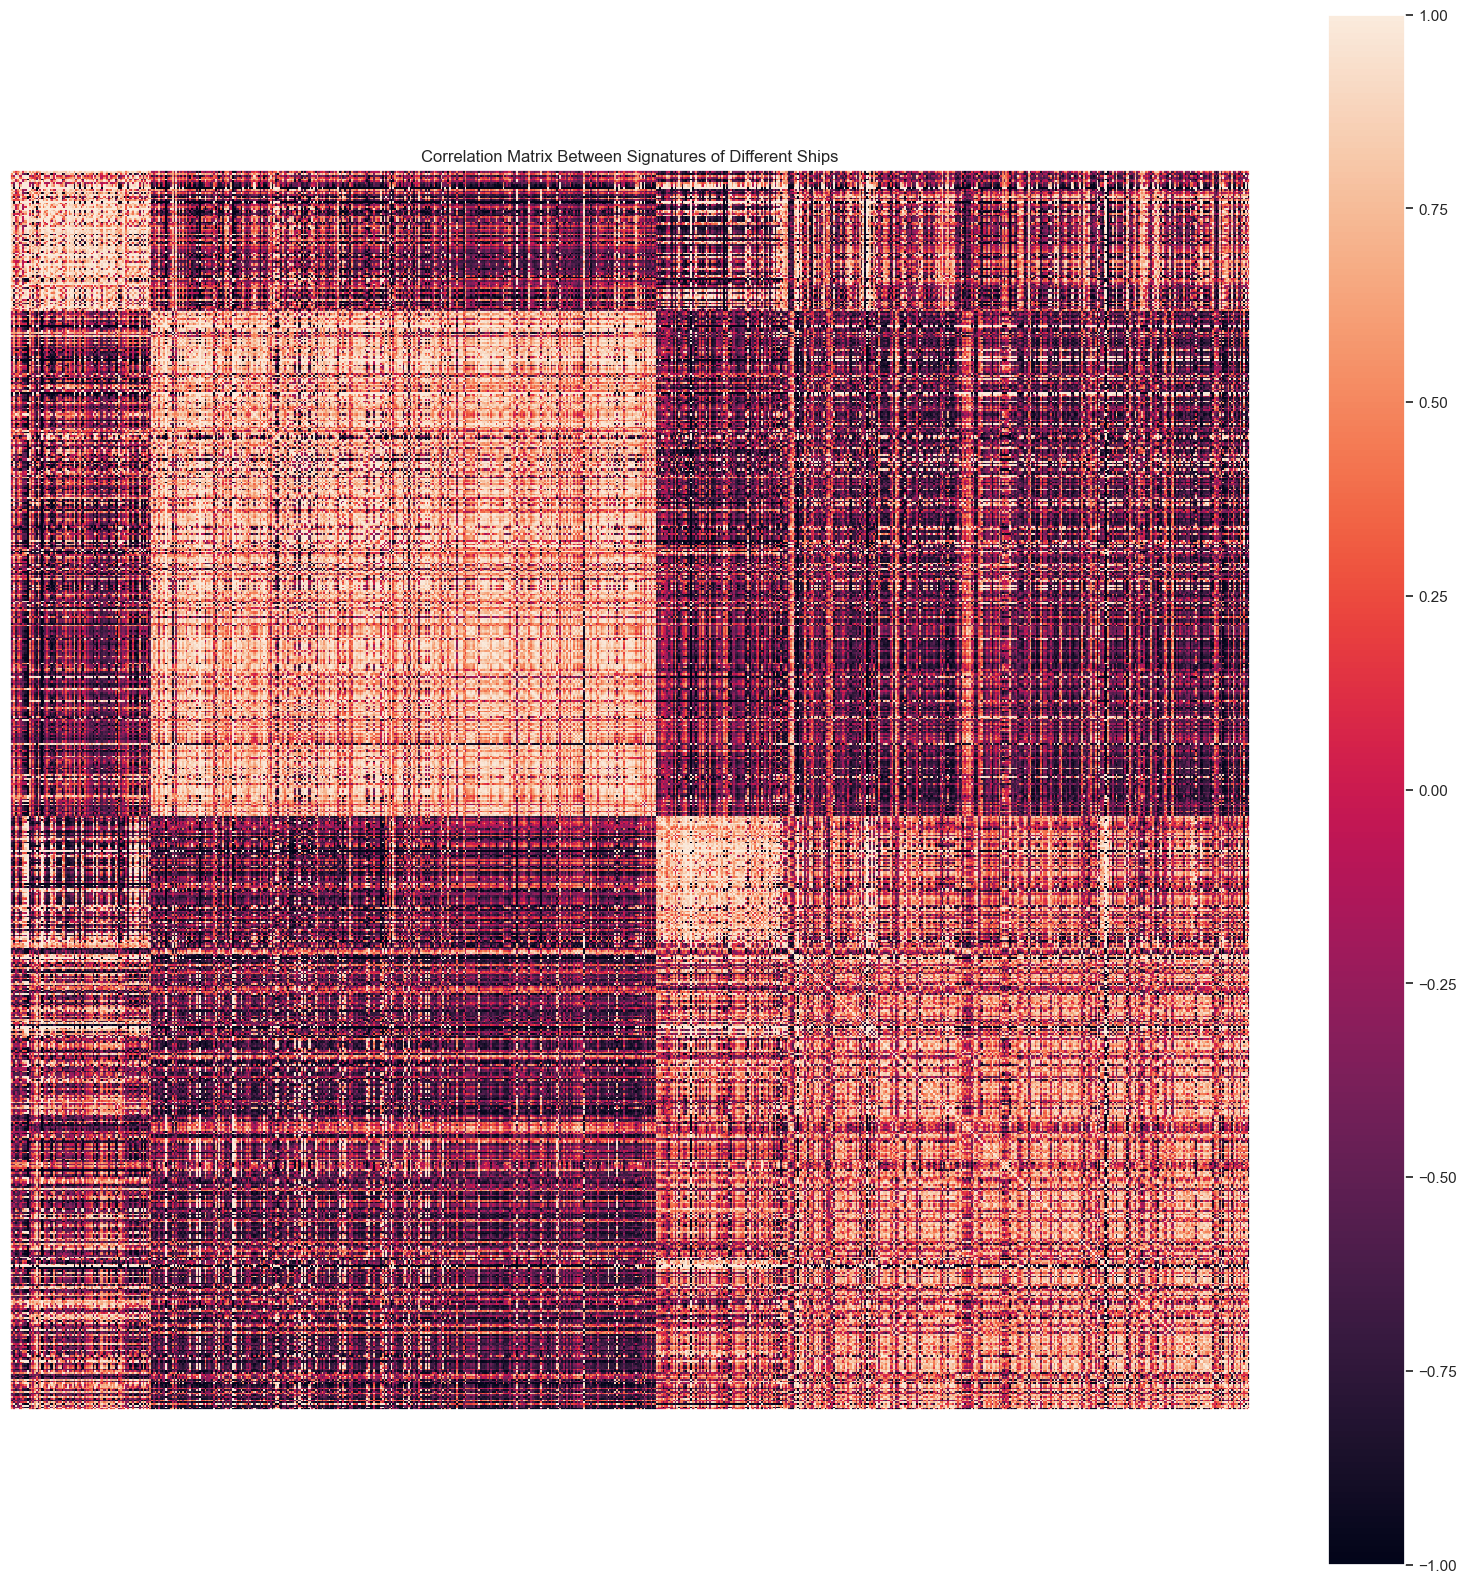

In [19]:
# Sort the aggragated data by the predicted labels
aggregated_data["label"] = all_signatures_labels
aggregated_data = aggregated_data.sort_values(by="label")
aggregated_data.drop(columns=["label"], inplace=True)

# Correlation matirx between signatures of different ships
correlation_matrix = aggregated_data.T.corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation_matrix, fignum=1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title("Correlation Matrix Between Signatures of Different Ships")
plt.show()
